In [12]:
'''
Uses slabspec and LineFluxCalcandFit_Functions to generate slab models for low-, high-, and all J-term transitions 
for a given species
Saves the outputs to an output file.

To do:
- set up plot saving to plot_location directory
'''

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.units as u
from astropy.constants import c
from astropy import units as un
from astropy.table import Table, vstack 
import pickle as pickle
import os as os
import pandas as pd
import math
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import chisquare
from spectools_ir.utils import extract_hitran_data, spec_convol, make_rotation_diagram, get_molmass
from spectools_ir.utils import compute_thermal_velocity, sigma_to_fwhm, fwhm_to_sigma, wn_to_k, spec_convol_R
from spectools_ir.utils import get_miri_mrs_resolution, get_miri_mrs_wavelengths, make_miri_mrs_figure
from spectools_ir.flux_calculator import calc_fluxes, make_lineshape, helpers
from spectools_ir.slabspec import make_spec
from spectools_ir.slab_fitter import Config, LineData,Retrieval
from spectools_ir.slab_fitter import corner_plot, trace_plot, find_best_fit, compute_model_fluxes
from spectools_ir.slab_fitter import calc_solid_angle, calc_radius
from spectools_ir.slab_fitter import read_data_from_file, get_samples
# !! import this to angela:
from LineFluxCalcandFit_Functions import *

# define variables:

'''
Source options as of 7/24/25:
AATau
AS209
BPTau
CYTau
DoAr25
FZTau
GOTau
HD143006
HD163296
HTLup
IRAS04385
SR21
V892Tau

Adding more will require adding lines to the input file and including their inclination, stellar mass, and distance
'''

# Define variables and paths - - - - - - - - - - - - - - - - - 

source_name = 'FZTau'
cont_jy = 1.05 # define continuum value, if any (janskys)
plot_query = 1 # if 1, will generate plots; if 0, will not
run_index = 0 # change this if running multiple runs for the same source; will change the directory name they're saved in
# load source info from source list

# load the distance, inclination, and mass of the source of interest (I use my own list here)
source_list = np.loadtxt('/Users/emmadahl/Desktop/NIRSPEC_data/source_list', dtype=str) # list of sources and their characteristics
list_index = np.where(source_list == source_name)[0][0]
distance = float(source_list[list_index][1]) # distance (pc)
inc = float(source_list[list_index][2]) # inclination (deg)
M_star = float(source_list[list_index][3]) # M_star (M_solar)

# config file for slabspec routine; I have my own default file pointed to here
config_file = '/Users/emmadahl/Desktop/Slabs/config_files/default_config.txt' # for models !! might want to make different ones for different parts of the disk?
# path+name of csv file containing spectra
datafile = '/Users/emmadahl/Desktop/NIRSPEC_data/'+source_name+'/'+source_name+'_fullstack.csv'
# location of plots but also output files, pickle files, etc.
plot_location = '/Users/emmadahl/Desktop/slabspec_guess_plots/'+source_name+'_'+str(run_index)+'/'
os.system('mkdir '+plot_location) # make the directory in which to save results if not already there
# name of output file
output_file = source_name+'_output_'+str(run_index)
# file names to which retrieval info will be saved
chain_name = 'disk_chain.p'
sampler_name = 'disk_sampler.p'

# !! choose which species we want to model here. label will be used in the output file
hitran_data = hitran_CO_low_vup; label = 'CO_vup_1' # vup = 1, 12CO

wl, flux, flux_error, wl_min, wl_max, w_min_inter, w_max_inter = readin(datafile)

# Load hitran data  - - - - - - - - - - - - - - - - - - - -
# For Emma's reference:
# Wavelength sorting + P-labels deal with empirical division of high- and low-energy rotational J transitions. 
# Global energy quanta sets the division between different types of vibrational v transitions.

hitran_CO_all = extract_hitran_data('CO', 4.6, 5.17) # all CO lines
hitran_CO_low_vup = extract_hitran_data('CO', 4.6, 5.17, vup=1) # v=1-0 vibrational transition (more energy than J)
hitran_CO_high_vup = extract_hitran_data('CO', 4.6, 5.17, vup=2) # v=2-1
hitran_13CO = extract_hitran_data('CO', 4.6, 5.17, isotopologue_number=2) # 13CO, all lines
hitran_H2O = extract_hitran_data('H2O', 4.6, 5.17) # H2O, all lines


mkdir: /Users/emmadahl/Desktop/slabspec_guess_plots/FZTau_0/: File exists


In [2]:
# run manual and modified version of calc_fluxes() 

from spectools_ir.flux_calculator import calc_fluxes, make_lineshape, helpers

# pulling lines from calc_fluxes() in slabspec to make the same astropy table
# based on values Colette used in exmaple notebook. maybe make these variables in the future but can probably leave them for first guesses
'''fwhm_v=40.
sep_v=200.
cont=np.copy(cont_jy)
verbose=True
vet_fits=False
plot=True
v_dop=0
amp=0.1
ymin=None
ymax=None
bounds=None
wave = np.copy(wl)'''

plot_query = 1

def manual_line_fitting(wave, flux, hitran_data, t_list, fwhm_v=40., sep_v=200.,cont=np.copy(cont_jy),verbose=True,vet_fits=False,
                plot=True,v_dop=0,amp=0.1,ymin=None,ymax=None,bounds=None): # add variable of transition/wavelength list

    lineflux_data=helpers._convert_quantum_strings(hitran_data)
    lineflux_data=helpers._strip_superfluous_hitran_data(lineflux_data)
    
    nlines=np.size(lineflux_data)
    #Add new columns to astropy table to hold line fluxes and error bars
    lineflux_data['lineflux']=np.zeros(nlines)  
    lineflux_data['lineflux_Gaussian']=np.zeros(nlines)  
    lineflux_data['lineflux_err']=np.zeros(nlines)  
    lineflux_data['linewidth']=np.zeros(nlines)
    lineflux_data['linewidth_err']=np.zeros(nlines)
    lineflux_data['v_dop_fit']=np.zeros(nlines)  
    lineflux_data['v_dop_fit_err']=np.zeros(nlines)  
    lineflux_data['continuum']=np.zeros(nlines)  
    lineflux_data['continuum_err']=np.zeros(nlines)  
    lineflux_data['wave_fit']=np.zeros(nlines)  
    lineflux_data['wave_fit_err']=np.zeros(nlines)  
    lineflux_data['amp_fit']=np.zeros(nlines)  
    lineflux_data['amp_fit_err']=np.zeros(nlines)  
    goodfit_bool=[True]*nlines
    
    for i,w0 in enumerate(lineflux_data['wave']): 
        for pp in t_list: 
            if pp in lineflux_data['Qpp_HITRAN'][i]: 
                print(pp, lineflux_data['Qpp_HITRAN'][i])
                # if the hitran transition is listed in the allowed transition list:
                #print(w0)
                wdop=v_dop*1e3/c.value*w0
                dw=sep_v*1e3/c.value*w0
                dw2=2*sep_v*1e3/c.value*w0
                sig_w=fwhm_to_sigma(fwhm_v*1e3/c.value*w0)
                mybool=((wave>(w0+wdop-dw)) & (wave<(w0+wdop+dw)) & np.isfinite(flux))
                myx=wave[mybool]
                myy=flux[mybool]
                if((len(myx) <= 5) & (verbose==True) ):
                    print('Not enough data near ', w0+wdop, ' microns. Skipping.')
                    goodfit_bool[i]=False
                if(len(myx) > 5):
                    print('Starting params:',amp,w0+wdop,sig_w,cont)
                    g=helpers._line_fit(np.array(myx),np.array(myy),nterms=4,p0=[amp,w0+wdop,sig_w,cont],bounds=bounds)
            
                    if  g != -1: # check if slabspec thinks it fit. uses the gradient of the left side of the curve to determine if there is a fit
                        # will be biased if there's no data on the left side of the center but data on the other side !!
                        grad = np.gradient(g['yfit'][0:(int(len(g['yfit'])/2-2))])
                        print(len(np.where(grad < 0)[0]), len(np.where(grad > 0)[0]))
                        if len(np.where(grad < 0)[0]) >= len(np.where(grad > 0)[0]):
                            print('! negative/flat fit ! rejecting...')
                            g=-1 # update g
            
                    if(g!=-1):   #curve fit succeeded
            
                        # plot fit upclose
                        #plt.plot(myx,myy)
                        #plt.plot(myx,g['yfit'])
                        
                        p=g['parameters']
                        print('Fit params:', p[0],p[1],p[2],p[3])
                        perr=g['parameter_errors']
                        resid=g['resid']
                        sigflux=np.sqrt(np.mean(resid**2.))
                        (lineflux,lineflux_err)=helpers._calc_line_flux_from_fit(p,sigflux=sigflux)
                        lineflux_data['lineflux_Gaussian'][i]=lineflux.value
                        lineflux_data['lineflux_err'][i]=lineflux_err.value
                        lineflux_num=helpers._calc_numerical_flux(myx,myy,p)
                        lineflux_data['lineflux'][i]=lineflux_num.value
                        lineflux_data['linewidth'][i]=np.abs((helpers._calc_linewidth(p,perr=perr))[0].value)
                        lineflux_data['linewidth_err'][i]=np.abs((helpers._calc_linewidth(p,perr=perr))[1].value)
                        lineflux_data['v_dop_fit'][i]=(p[1]-w0)/w0*c.value*1e-3   #km/s
                        lineflux_data['v_dop_fit_err'][i]=(perr[1])/w0*c.value*1e-3   #km/s
                        lineflux_data['continuum'][i]=(p[3])   #Jy
                        lineflux_data['continuum_err'][i]=(perr[3])   #Jy
            
                        lineflux_data['wave_fit'][i]=p[1] #microns
                        lineflux_data['wave_fit_err'][i]=perr[1] #microns
                        lineflux_data['amp_fit'][i]=p[0] #Jy
                        lineflux_data['amp_fit_err'][i]=perr[0] #Jy
            
                        # calculate the reduced chi sq within the numberical limits; wasn't very indicative of a poor fit when stuff was wonky so commented out
                        #print('chisq = ',chisquare(myy, g['yfit'], ddof=4))
                                        
                        if(plot_query==1):
                            fig=plt.figure(figsize=(10,3))
                            ax1=fig.add_subplot(111)
                            ax1.plot(wave,flux,'C0',drawstyle='steps-mid',label='All data')
                            ax1.plot(myx,myy,'C1',drawstyle='steps-mid',label='Fit data')
                            ax1.plot(myx,g['yfit'],'C2', linestyle='-',label='Fit')
                            ax1.axvline(w0+wdop,color='C3',label='Line center')
                            ax1.set_xlim(np.min(myx)-dw2,np.max(myx)+dw2)
                            if(ymin is None): ymin=np.min(myy)
                            if(ymax is None): ymax=2+np.min(myy)
                            ax1.set_ylim(ymin,ymax)
                            ax1.set_xlabel(r'Wavelength [$\mu$m]')
                            ax1.set_ylabel(r'F$_\nu$ [Jy]')
                            ax1.axvline(p[1]-3*p[2],label='Numerical limit',color='C3',linestyle='--')
                            ax1.axvline(p[1]+3*p[2],color='C3',linestyle='--')
                            ax1.legend()
                            if('Qpp' in hitran_data.columns): ax1.set_title(hitran_data['Qpp'][i])
                            plt.show(block=False)
                            plt.close() 
                    elif(g==-1):   #curve fit failed
                        print('!! Curve fit failed !!')
                        goodfit_bool[i]=False
                        if(plot==True):
                            fig=plt.figure(figsize=(10,3))
                            ax1=fig.add_subplot(111)
                            ax1.plot(wave,flux,'C0',drawstyle='steps-mid',label='All data')
                            ax1.plot(myx,myy,'C1',drawstyle='steps-mid',label='Fit data')
                            ax1.axvline(w0+wdop,color='C3',label='Line center')
                            ax1.set_xlim(np.min(myx)-dw2,np.max(myx)+dw2)
                            if(ymin is None): ymin=np.min(myy)
                            if(ymax is None): ymax=2+np.min(myy)
                            ax1.set_ylim(ymin,ymax)
                            ax1.set_xlabel(r'Wavelength [$\mu$m]')
                            ax1.set_ylabel(r'F$_\nu$ [Jy]')
                            ax1.legend()
                            if('Qpp' in hitran_data.columns): ax1.set_title(hitran_data['Qpp'][i])
                            plt.show(block=False)
                            plt.pause(0.5)
                            plt.close()
                            
    lineflux_data['lineflux'].unit = 'W / m2'
    lineflux_data['lineflux_err'].unit = 'W / m2'
    lineflux_data['linewidth'].unit = 'km / s'
    lineflux_data['linewidth_err'].unit = 'km / s'
    lineflux_data['v_dop_fit'].unit = 'km / s'
    lineflux_data['v_dop_fit_err'].unit = 'km / s'
    lineflux_data['continuum'].unit = 'Jy'
    lineflux_data['continuum_err'].unit = 'Jy'
    lineflux_data['amp_fit'].unit = 'Jy'
    lineflux_data['amp_fit_err'].unit = 'Jy'
    lineflux_data['wave_fit'].unit = 'micron'
    lineflux_data['wave_fit_err'].unit = 'micron'
    
    #lineflux_data=lineflux_data[goodfit_bool]
    
    # delete empty rows
    lineflux_data.remove_rows(np.where(lineflux_data['lineflux'] == 0.0)[0])
    # delete row with negative flux
    lineflux_data.remove_rows(np.where(lineflux_data['lineflux'] < 0.0)[0])

    return lineflux_data

In [21]:
def slabspec_routines(wl, flux, wl_min, wl_max, lineflux_data, distance, config_file, 
                      chain_name='disk_chain.p', sampler_name='disk_sampler.p', run_retrieval=1, plot_query=0):
    '''
    automating line flux calculations and retrievals
    
    inputs
    run_retrieval - 0, won't run retrieval; 1, will run retrieval

    outputs (keeping units consistent with slabspec outputs; set up to convert them w/ iris)
    log N, in m^-2
    log postive and negative error bounds for log N
    T, in K
    postive and negative error bounds for K
    log A, in **radians**
    log postive and negative error bounds for log A
    '''
    
    lineshape_data=make_lineshape(wl,flux,lineflux_data)
    #lineshape_data=((stackv, stackf+1))
    if plot_query==1:
        fig=plt.figure()
        ax1=fig.add_subplot(111)
        ax1.plot(lineshape_data[0],lineshape_data[1])
        ax1.legend()
        ax1.set_xlabel('Velocity [km/s]')
        ax1.set_ylabel('Arbitrary flux')

    # make rotation diagram 
    rot_numerical=make_rotation_diagram(lineflux_data,fluxkey='lineflux')
    rot_Gaussian=make_rotation_diagram(lineflux_data,fluxkey='lineflux_Gaussian')

    if plot_query==1:
        fig=plt.figure()
        ax1=fig.add_subplot(111)
        ax1.plot(rot_numerical['x'],rot_numerical['y'],'C0o',label='Numerical fit')
        ax1.errorbar(rot_numerical['x'],rot_numerical['y'],yerr=rot_numerical['yerr'],color='C0',fmt='None')
        
        ax1.plot(rot_Gaussian['x'],rot_Gaussian['y'],'C1o', label='Gaussian fit')
        ax1.errorbar(rot_Gaussian['x'],rot_Gaussian['y'],yerr=rot_Gaussian['yerr'],color='C1',fmt='None')
        
        ax1.set_xlabel('Eup [K]')
        ax1.set_ylabel(r'ln(F/(gA$\tilde{\nu}$))')
        ax1.legend()

    # default 
    au=1.5e11 # meters/AU
    #Make slab model based on some hard-coded default values # !! hard-coded, maybe change these
    model_output=make_spec('CO',1e22,1000,np.pi*(0.3*au)**2., wmin=wl_min,wmax=wl_max,convol_fwhm=30.,d_pc=distance,vup=1)
    
    rd_model=make_rotation_diagram(model_output['lineparams'])
    rd_data=make_rotation_diagram(lineflux_data)

    if plot_query == 1:
        # plot line flux vs. wavelength
        fig=plt.figure()
        ax1=fig.add_subplot(111)
        ax1.plot(lineflux_data['wave'],lineflux_data['lineflux']*1e16,'-o',label='Numerical flux')
        ax1.plot(lineflux_data['wave'],lineflux_data['lineflux_Gaussian']*1e16 ,label='Gaussian flux')
        ax1.legend()
        ax1.set_xlabel('Wavelength [microns]')
        ax1.set_ylabel(r'Line flux [10$^{-16}$ W m$^{-2}$]')

    if plot_query == 1:
        #Plot slab model
        fig=plt.figure(figsize=(10,3))
        ax1=fig.add_subplot(111)
        ax1.plot(model_output['spectrum']['wave'],model_output['spectrum']['flux']+1,label='Not convolved')
        ax1.plot(model_output['spectrum']['wave'],model_output['spectrum']['convolflux']+1,'r',label='Convolved')
        ax1.legend()

    myconfig=Config(config_file)  #reads config.json by default, or can specify path to file as input parameter
    #myconfig=Config()  #reads config.json by default, or can specify path to file as input parameter
    
    myconfig.display()
    
    data=lineflux_data
    mydata=LineData(data)
    myretrieval=Retrieval(myconfig,mydata)

    if plot_query == 1:
        fig=plt.figure()
        ax1=fig.add_subplot(111)
        ax1.plot(rd_model['x'],rd_model['y'],' C0o',label='Model')
        ax1.plot(rd_data['x'],rd_data['y'],' C1*',label='Data')
        ax1.errorbar(rd_data['x'],rd_data['y'],yerr=rd_data['yerr'],color='C1',fmt='None')
        
        ax1.set_xlabel('Eup [K]')
        ax1.set_ylabel(r'ln(F/(gA$\tilde{\nu}$)) (line flux)')
        ax1.legend()
        
    # run retrieval
    if run_retrieval == 1:
        print('running retrieval...')
        mysampler=myretrieval.run_emcee()  #Run retrieval.  May take a while, depending on number of samples
        mychain=mysampler.chain
        pickle.dump(mychain,open(chain_name,'wb'))  #Save for convenience and later retrieval
        pickle.dump(mysampler,open(sampler_name,'wb'))  #Save for convenience and later retrieval
        os.system('afplay /System/Library/Sounds/Bottle.aiff -v 8')

    mychain=pickle.load(open(chain_name,'rb'))  
    postsamples=get_samples(mychain,myconfig.getpar('Nburnin'))  #Get list of samples, after removing burnin, from chain
    if plot_query == 1:
        trace_plot(postsamples)
        fig=corner_plot(postsamples)

    best_fit=find_best_fit(postsamples,show=True)
    logN=best_fit['logN']; logN_perr=best_fit['logN_perr']; logN_nerr=best_fit['logN_nerr']
    T=best_fit['T']; T_perr=best_fit['T_perr']; T_nerr=best_fit['T_nerr']
    logOmega=best_fit['logOmega']; logOmega_perr=best_fit['logOmega_perr']; logOmega_nerr=best_fit['logOmega_nerr']
    
    return logN, logN_perr, logN_nerr, T, T_perr, T_nerr, logOmega, logOmega_perr, logOmega_nerr

## Find info for given species (defined in first cell)

1
Measured line appears to be at: nan Jy
!! Ignoring this transition due to lack of total available datapoints (less than 40.0%) !!
2
Measured line appears to be at: 1.5947284446506667 Jy
Difference:
Measured flux wl: 5.1329281312189705
Hitran line wl: 5.1327686
0.00015950023752520082
3
Measured line appears to be at: 1.696808210273457 Jy
Difference:
Measured flux wl: 5.119115311299335
Hitran line wl: 5.1191497
-3.437360667124523e-05
4
Measured line appears to be at: 1.7585713796041247 Jy
Difference:
Measured flux wl: 5.1055219803688425
Hitran line wl: 5.1056786
-0.0001565779807668477
5
Measured line appears to be at: 1.8376888000357254 Jy
Difference:
Measured flux wl: 5.092312281028236
Hitran line wl: 5.092353
-4.05860982288786e-05
6
Measured line appears to be at: 1.8900218272051645 Jy
Difference:
Measured flux wl: 5.079212824574672
Hitran line wl: 5.079172
4.069017525765162e-05
7
Measured line appears to be at: 1.881971161315539 Jy
Difference:
Measured flux wl: 5.066147318546446
Hit

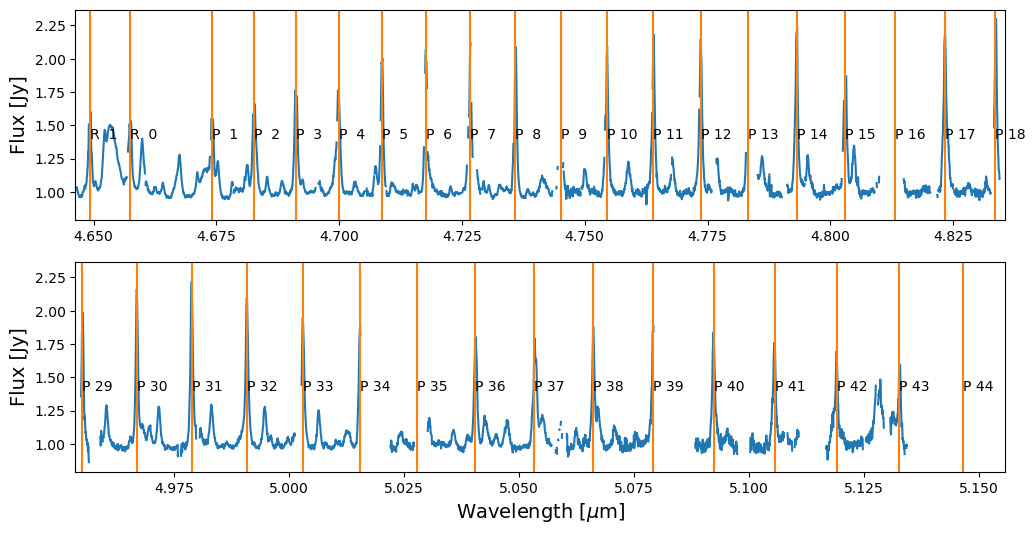

<Figure size 600x600 with 0 Axes>

In [10]:
# calculate transition info for a select group using some of Alexa's code

ids = fullplot(wl, flux, flux_error, wl_min, wl_max, w_min_inter, w_max_inter, hitran_data)

w_list, t_list, r_list = transitionfinder(wl, flux, flux_error, wl_min, wl_max, ids, hitran_data, plot_query=0, 
                                          delta_wl=5e-4, thresh=0.4)

In [5]:
# find low and high energy names and wavelengths (based on default value of P30)

lowen, highen, lowenname, highenname = energy_separator_transition(w_list, t_list) # modified version of energy_seperator()
#lowen, highen, lowenname, highenname = energy_separator_wl(w_list, t_list) # using transition name instead so commented out

P 43      P 43      
Starting params: 0.1 5.132768630981445 0.0002908260149844752 1.05
0 27
Fit params: 0.47410988887867606 5.132829626276192 0.00021907685334998653 1.1198026131481393


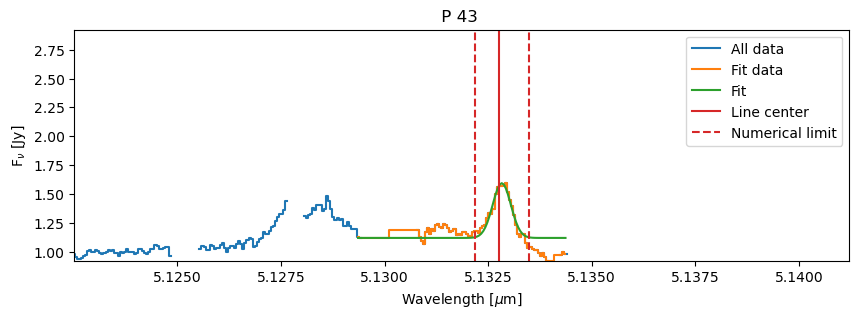

P 42      P 42      
Starting params: 0.1 5.119149684906006 0.0002900543566261573 1.05
11 46
Fit params: 0.5311059195128809 5.119062657837597 0.00040308999037219336 1.0108438636021566


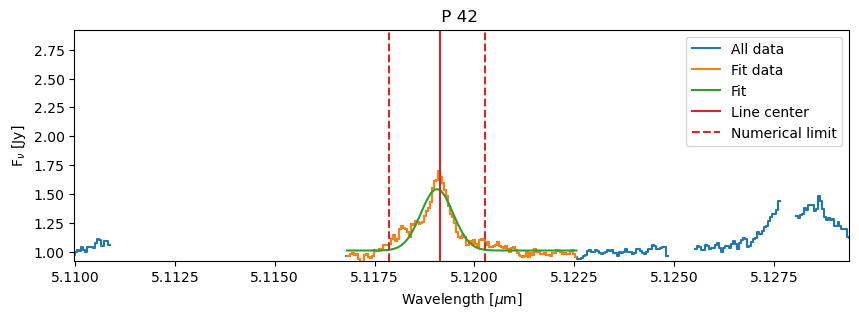

P 41      P 41      
Starting params: 0.1 5.105678558349609 0.00028929107381810306 1.05
0 48
Fit params: 0.7047865292492459 5.105572176734409 0.0003242819973078097 1.0124015714436387


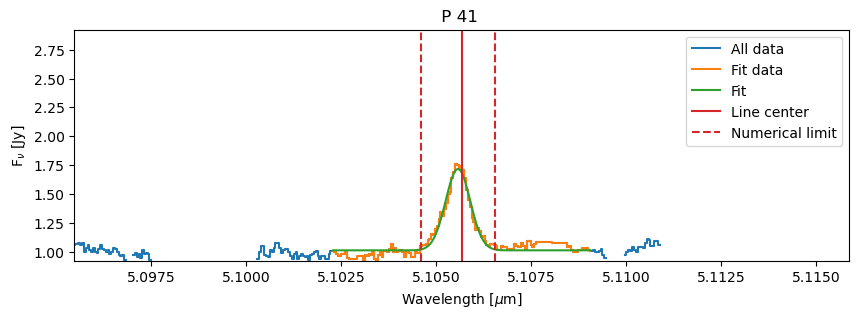

P 40      P 40      
Starting params: 0.1 5.092352867126465 0.000288536031470792 1.05
0 54
Fit params: 0.7669831710527201 5.0923536930077375 0.00030877485118975415 1.0156593358588129


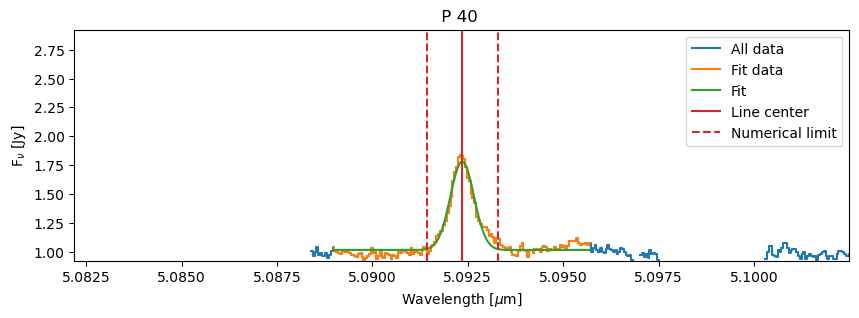

P 39      P 39      
Starting params: 0.1 5.079172134399414 0.0002877892025663201 1.05
0 34
Fit params: 0.9698052555572472 5.079416811148511 0.0004170262290010043 1.018844624635314


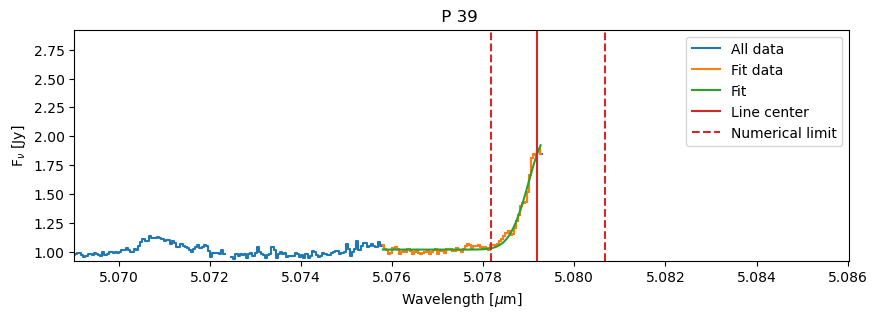

P 38      P 38      
Starting params: 0.1 5.066134452819824 0.00028705047903307103 1.05
0 51
Fit params: 0.7478866551829421 5.066206381622642 0.00029113259612956936 1.0376505464888093


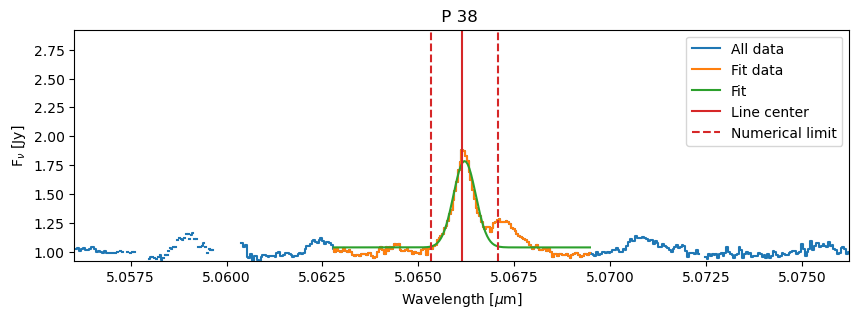

P 37      P 37      
Starting params: 0.1 5.053239345550537 0.0002863198338531407 1.05
0 54
Fit params: 0.6692233147487915 5.053534333538297 0.00039489038614177877 1.0363418865572724


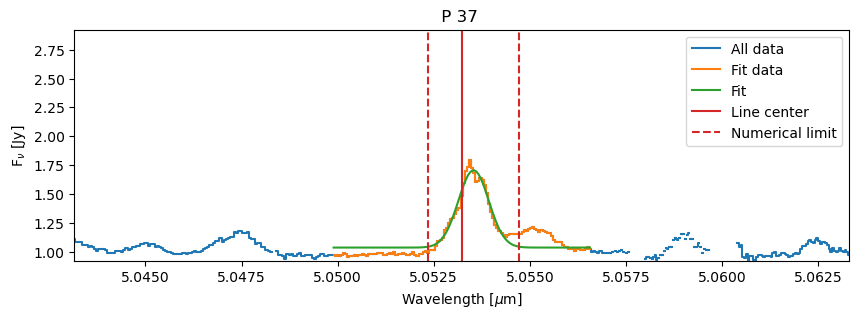

P 36      P 36      
Starting params: 0.1 5.040484428405762 0.00028559713193700875 1.05
0 44
Fit params: 0.7506595206074401 5.040580611391937 0.0002995953941783928 1.0419878311539619


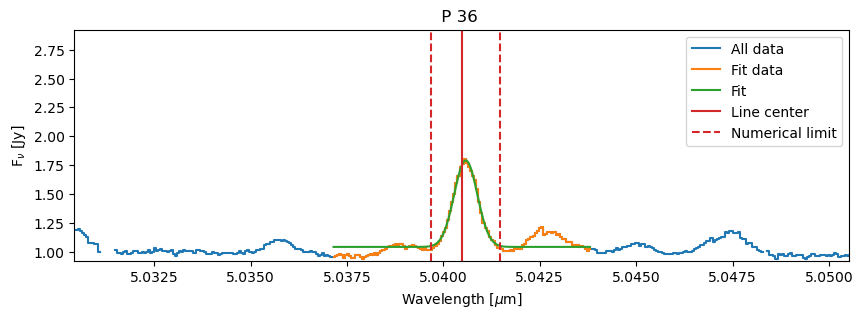

P 34      P 34      
Starting params: 0.1 5.015391826629639 0.00028417536877081153 1.05
0 9
Fit params: 0.8272408156026577 5.015423243316263 0.0002561527301502357 1.0368990931953117


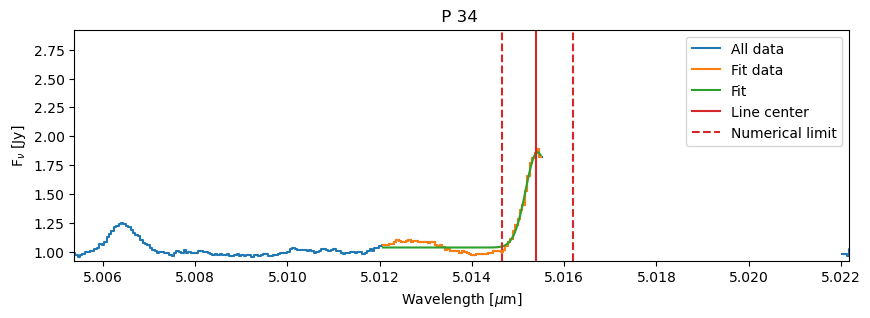

P 33      P 33      
Starting params: 0.1 5.003051280975342 0.0002834761454133217 1.05
12 19
Fit params: 0.8806969337435693 5.003025549977406 0.000277399910878443 1.0257872167662174


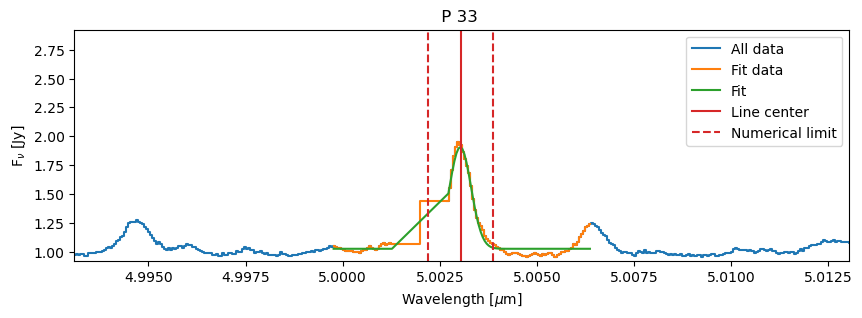

P 32      P 32      
Starting params: 0.1 4.990846633911133 0.0002827846221584936 1.05
0 51
Fit params: 1.0114328809334372 4.990823949348641 0.00030945401503407053 1.0140561982904324


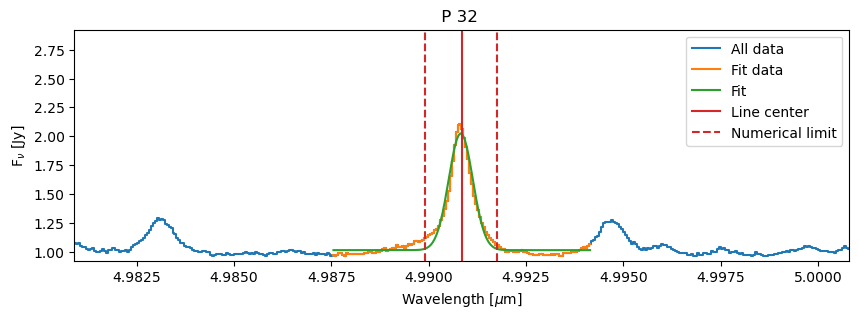

P 31      P 31      
Starting params: 0.1 4.978776931762695 0.00028210074497051906 1.05
0 44
Fit params: 1.1286508143409633 4.978807881635521 0.00028164162753188026 1.0151844212133403


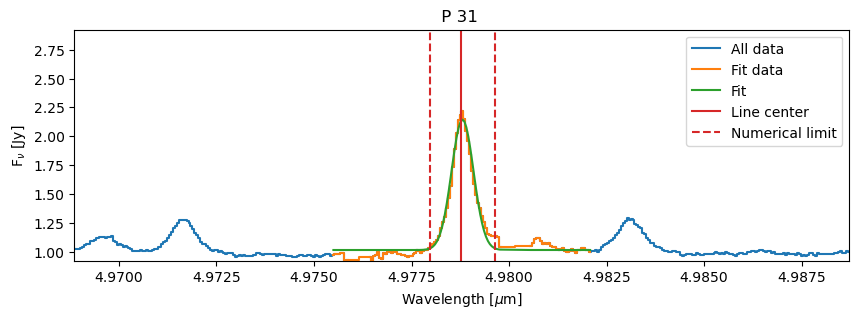

P 30      P 30      
Starting params: 0.1 4.9668402671813965 0.0002814244057777817 1.05
0 41
Fit params: 1.062064432693739 4.966877389798291 0.00024629448529834116 1.044559439174879


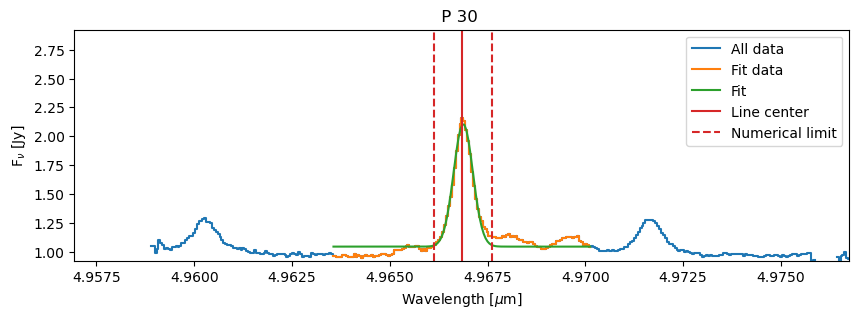

P 29      P 29      
Starting params: 0.1 4.955036163330078 0.0002807555775623775 1.05
9 7
! negative/flat fit ! rejecting...
!! Curve fit failed !!


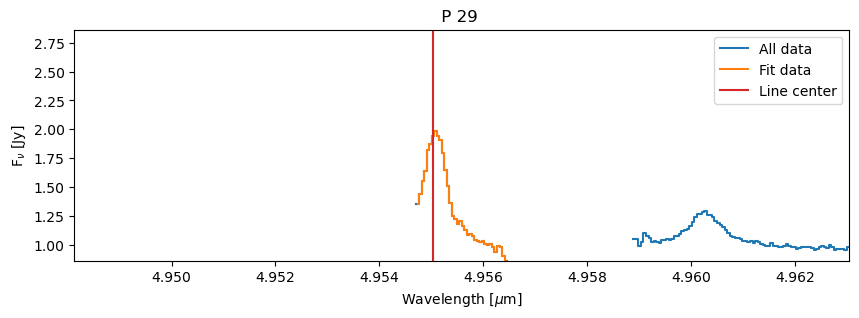

P 18      P 18      
Starting params: 0.1 4.833610534667969 0.0002738755223252036 1.05
0 11
Fit params: 1.177152365066292 4.833693402537468 0.00025755654483211105 1.0241398129640356


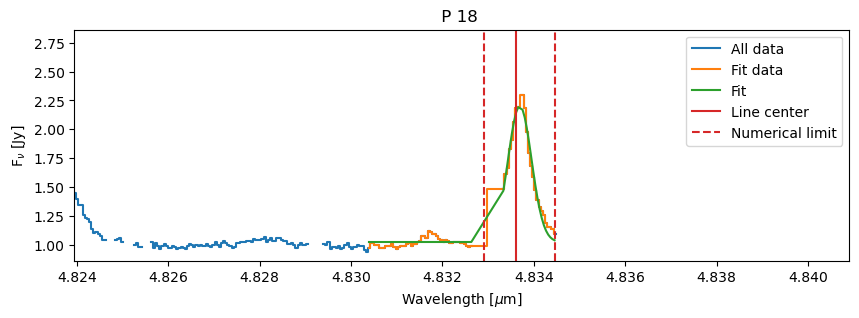

P 17      P 17      
Starting params: 0.1 4.823310852050781 0.0002732919355971596 1.05
6 39
Fit params: 1.0281061190410603 4.8233796711051244 0.00038561679108849216 1.0131986464337015


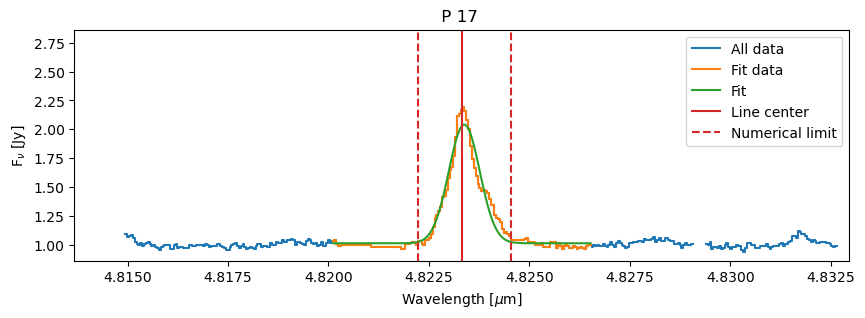

P 15      P 15      
Starting params: 0.1 4.803069114685059 0.00027214502556912863 1.05
2 41
Fit params: 0.9503956549741679 4.803037962328598 0.00027613190878098036 1.0727178389813576


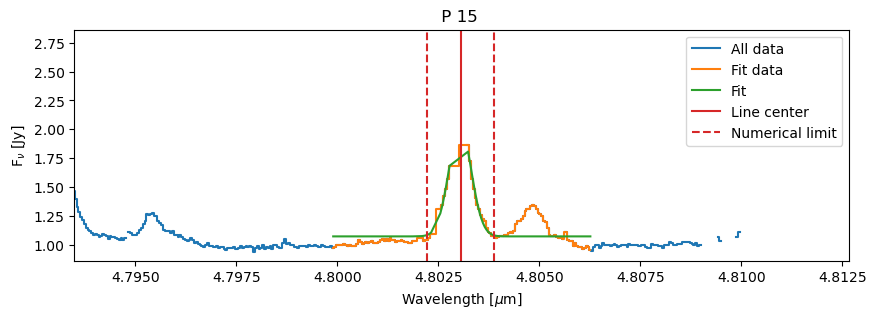

P 14      P 14      
Starting params: 0.1 4.793123722076416 0.00027158151314381315 1.05
7 45
Fit params: 1.082565534312843 4.793137970794396 0.00025701582779205705 1.079537125433602


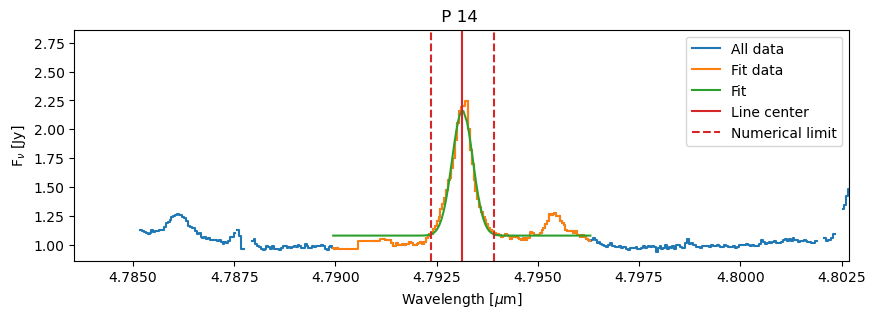

P 12      P 12      
Starting params: 0.1 4.77358341217041 0.0002704743464526781 1.05
0 45
Fit params: 1.0512319333349642 4.773616678031784 0.0002941785793277545 1.0151989619584476


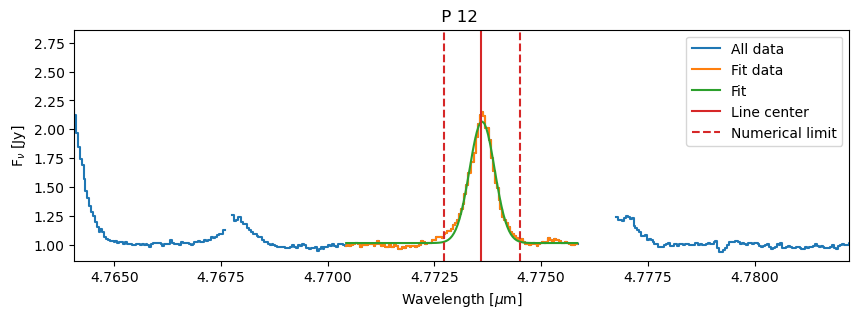

P 11      P 11      
Starting params: 0.1 4.763985633850098 0.00026993053007943416 1.05
0 54
Fit params: 1.0448181209443015 4.764006437647535 0.00028511402116965153 1.0118758438749575


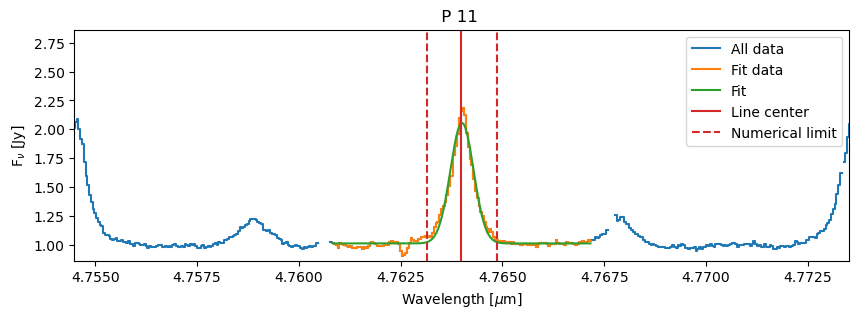

P 10      P 10      
Starting params: 0.1 4.754501819610596 0.0002693931709852643 1.05
0 57
Fit params: 0.925224139628204 4.754535406625543 0.0003066433342822541 1.0007797737029795


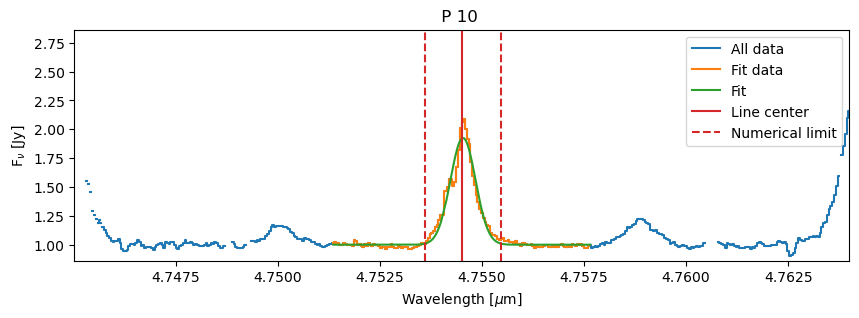

P  8      P  8      
Starting params: 0.1 4.735873222351074 0.00026833766252672283 1.05
0 39
Fit params: 1.0188185160622873 4.735938639195193 0.0002492847165594544 1.006075526098661


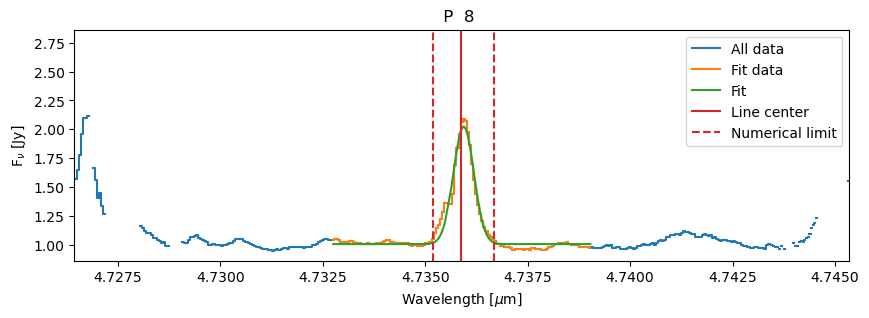

P  7      P  7      
Starting params: 0.1 4.72672700881958 0.0002678194321086389 1.05
0 27
Fit params: 0.973569017679023 4.726700619561221 0.0002690633689372607 1.0290103073587906


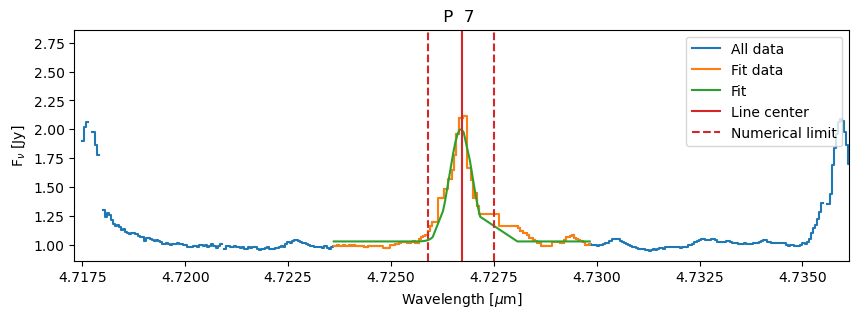

P  6      P  6      
Starting params: 0.1 4.717691421508789 0.00026730746984430067 1.05
0 41
Fit params: 1.0201781369739313 4.717661413144314 0.000263534718393928 1.0255735562846238


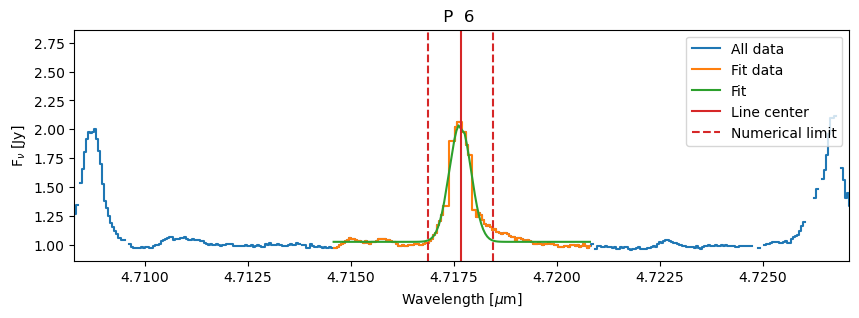

P  5      P  5      
Starting params: 0.1 4.708765983581543 0.000266801748715804 1.05
0 40
Fit params: 0.9727973143138916 4.708723118895721 0.00024637811116836884 1.0323684776727646


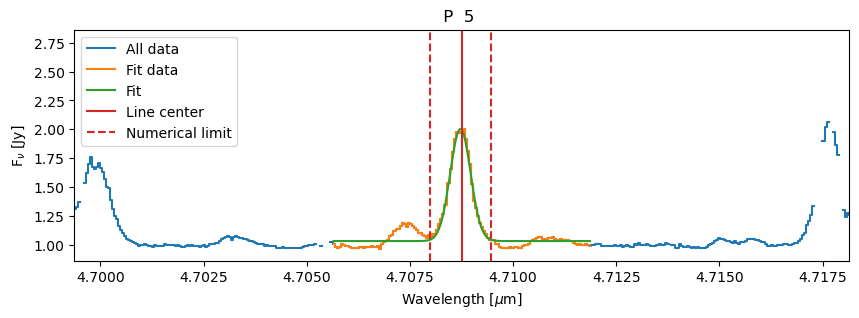

P 43      P 43      
Starting params: 0.1 5.132768630981445 0.0002908260149844752 1.05
0 27
Fit params: 0.47410988887867606 5.132829626276192 0.00021907685334998653 1.1198026131481393


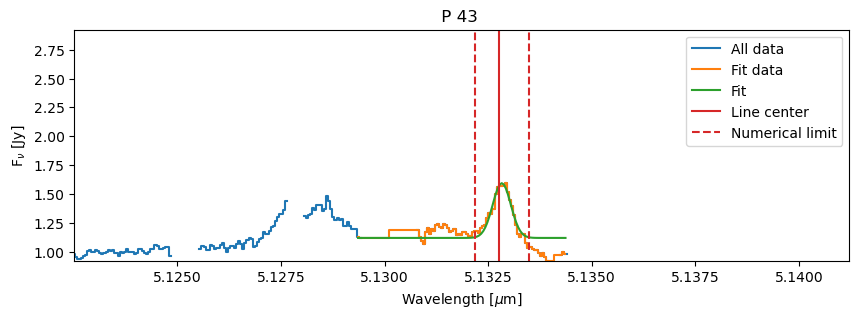

P 42      P 42      
Starting params: 0.1 5.119149684906006 0.0002900543566261573 1.05
11 46
Fit params: 0.5311059195128809 5.119062657837597 0.00040308999037219336 1.0108438636021566


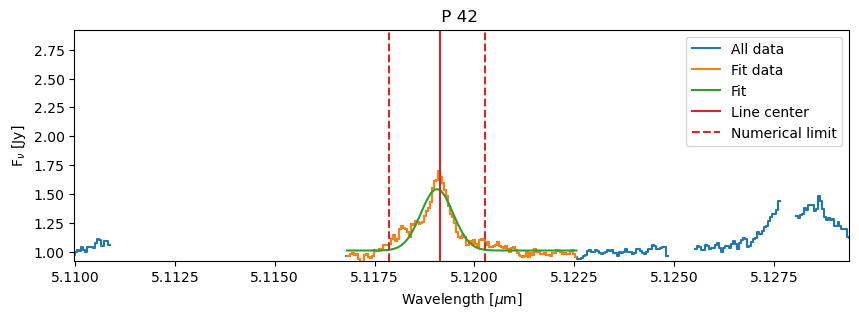

P 41      P 41      
Starting params: 0.1 5.105678558349609 0.00028929107381810306 1.05
0 48
Fit params: 0.7047865292492459 5.105572176734409 0.0003242819973078097 1.0124015714436387


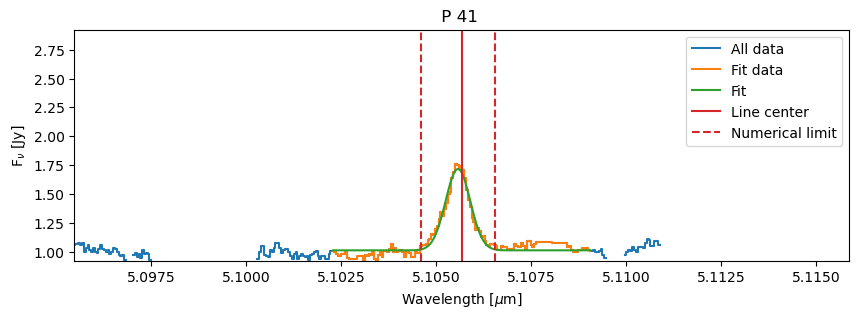

P 40      P 40      
Starting params: 0.1 5.092352867126465 0.000288536031470792 1.05
0 54
Fit params: 0.7669831710527201 5.0923536930077375 0.00030877485118975415 1.0156593358588129


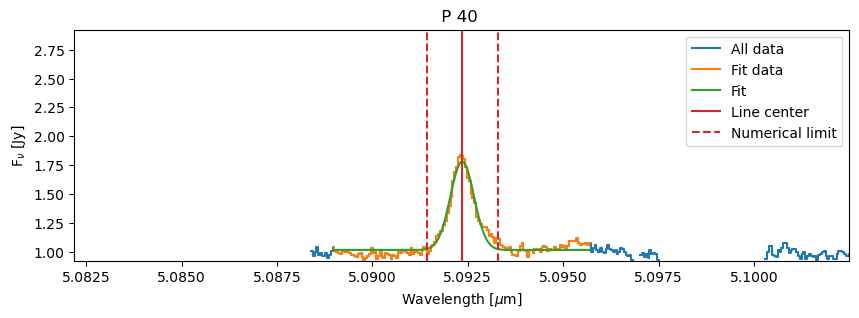

P 39      P 39      
Starting params: 0.1 5.079172134399414 0.0002877892025663201 1.05
0 34
Fit params: 0.9698052555572472 5.079416811148511 0.0004170262290010043 1.018844624635314


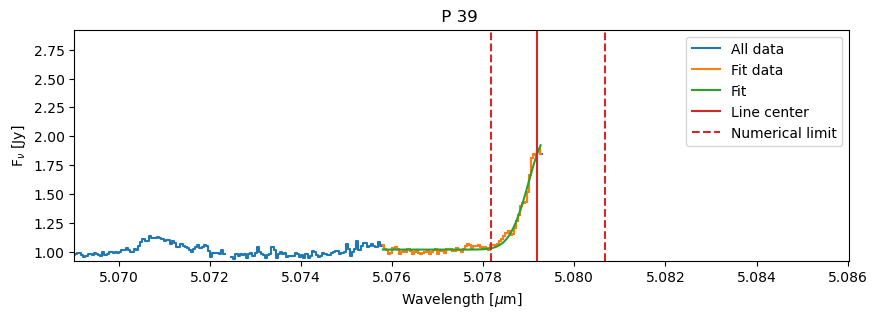

P 38      P 38      
Starting params: 0.1 5.066134452819824 0.00028705047903307103 1.05
0 51
Fit params: 0.7478866551829421 5.066206381622642 0.00029113259612956936 1.0376505464888093


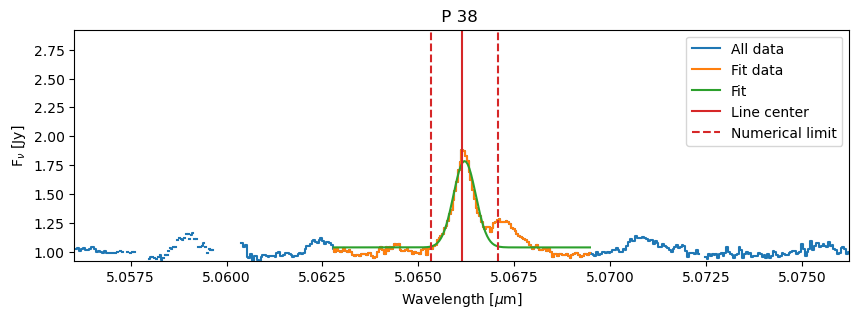

P 37      P 37      
Starting params: 0.1 5.053239345550537 0.0002863198338531407 1.05
0 54
Fit params: 0.6692233147487915 5.053534333538297 0.00039489038614177877 1.0363418865572724


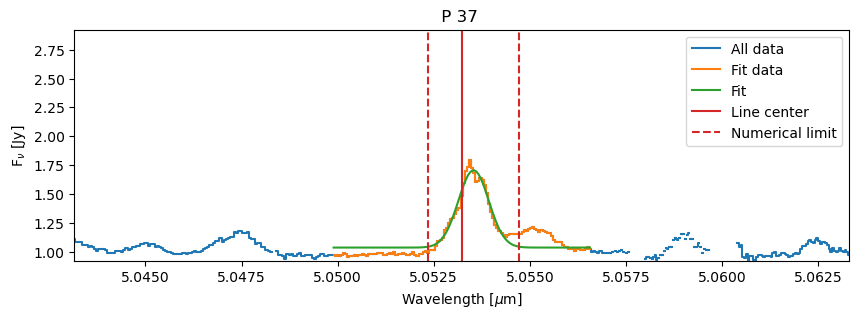

P 36      P 36      
Starting params: 0.1 5.040484428405762 0.00028559713193700875 1.05
0 44
Fit params: 0.7506595206074401 5.040580611391937 0.0002995953941783928 1.0419878311539619


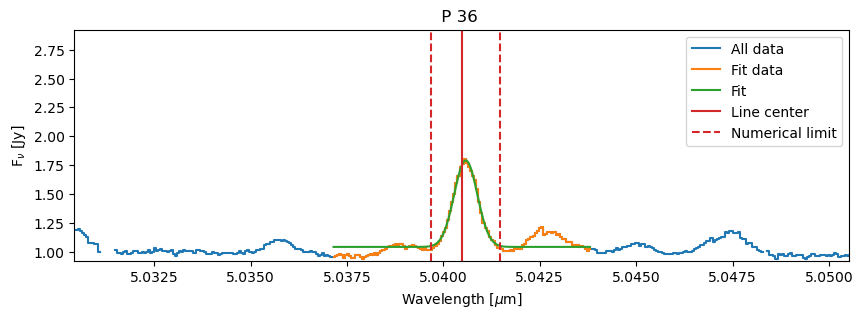

P 34      P 34      
Starting params: 0.1 5.015391826629639 0.00028417536877081153 1.05
0 9
Fit params: 0.8272408156026577 5.015423243316263 0.0002561527301502357 1.0368990931953117


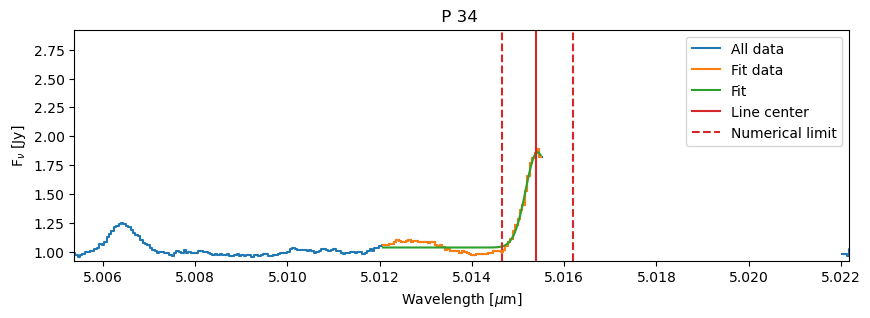

P 33      P 33      
Starting params: 0.1 5.003051280975342 0.0002834761454133217 1.05
12 19
Fit params: 0.8806969337435693 5.003025549977406 0.000277399910878443 1.0257872167662174


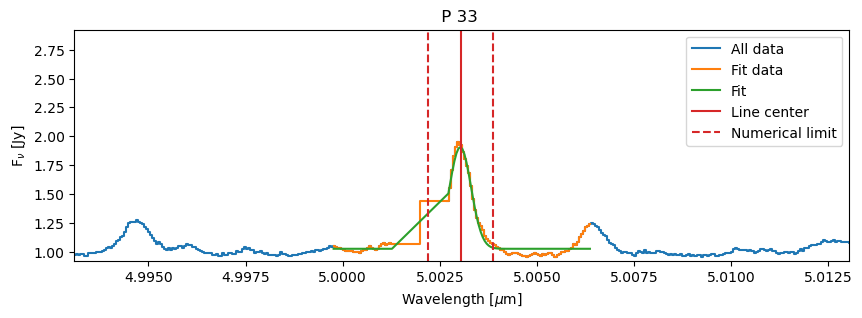

P 32      P 32      
Starting params: 0.1 4.990846633911133 0.0002827846221584936 1.05
0 51
Fit params: 1.0114328809334372 4.990823949348641 0.00030945401503407053 1.0140561982904324


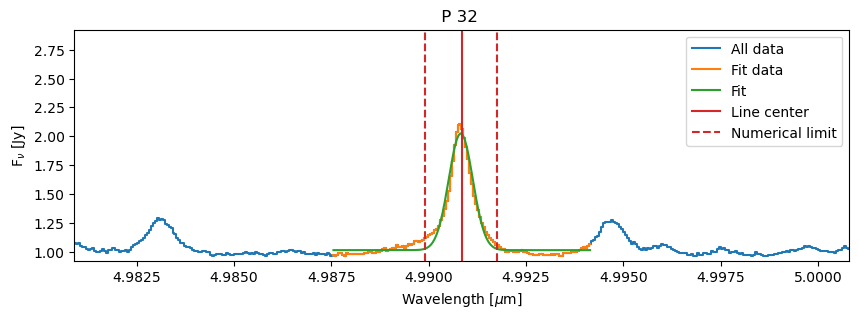

P 31      P 31      
Starting params: 0.1 4.978776931762695 0.00028210074497051906 1.05
0 44
Fit params: 1.1286508143409633 4.978807881635521 0.00028164162753188026 1.0151844212133403


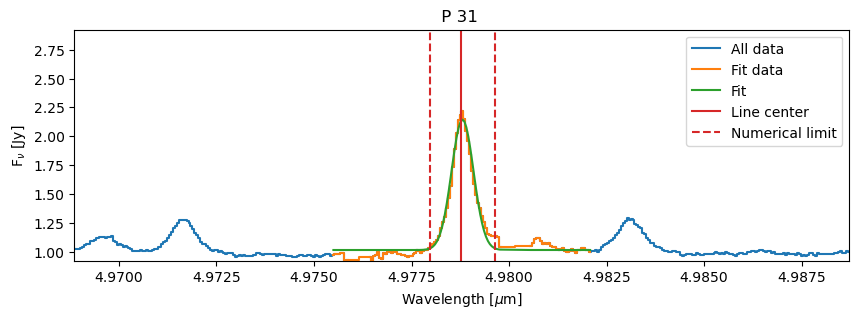

P 30      P 30      
Starting params: 0.1 4.9668402671813965 0.0002814244057777817 1.05
0 41
Fit params: 1.062064432693739 4.966877389798291 0.00024629448529834116 1.044559439174879


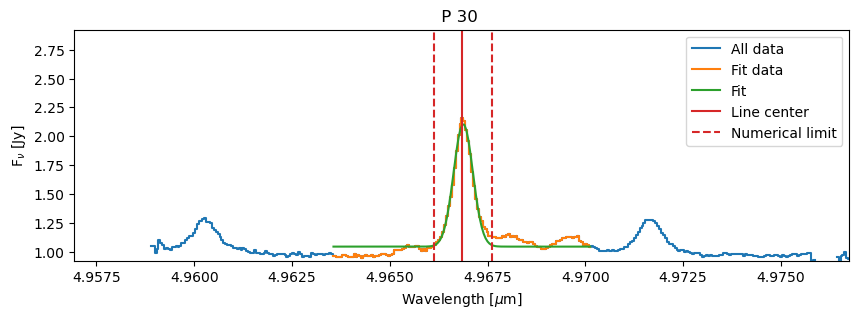

P 29      P 29      
Starting params: 0.1 4.955036163330078 0.0002807555775623775 1.05
9 7
! negative/flat fit ! rejecting...
!! Curve fit failed !!


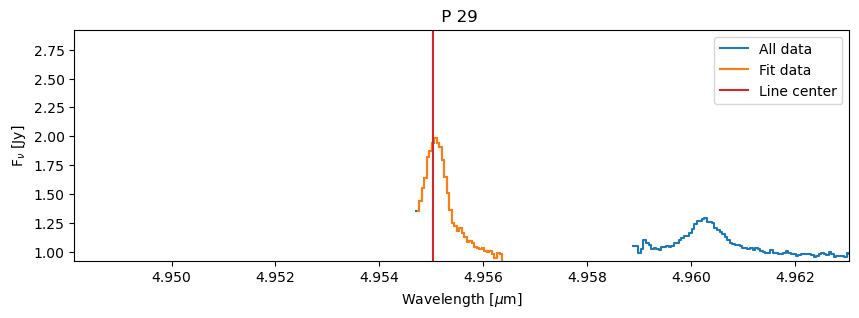

P 18      P 18      
Starting params: 0.1 4.833610534667969 0.0002738755223252036 1.05
0 11
Fit params: 1.177152365066292 4.833693402537468 0.00025755654483211105 1.0241398129640356


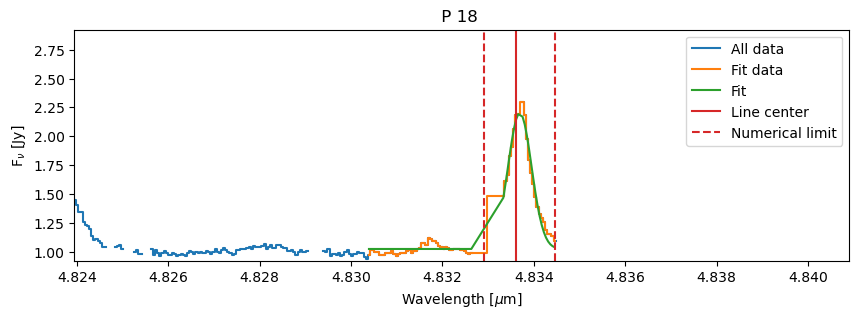

P 17      P 17      
Starting params: 0.1 4.823310852050781 0.0002732919355971596 1.05
6 39
Fit params: 1.0281061190410603 4.8233796711051244 0.00038561679108849216 1.0131986464337015


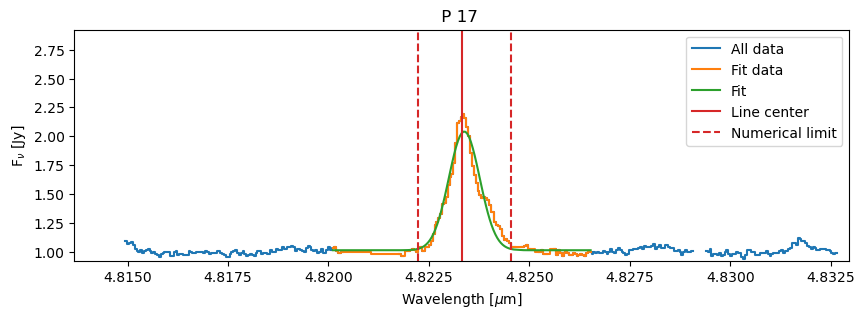

P 15      P 15      
Starting params: 0.1 4.803069114685059 0.00027214502556912863 1.05
2 41
Fit params: 0.9503956549741679 4.803037962328598 0.00027613190878098036 1.0727178389813576


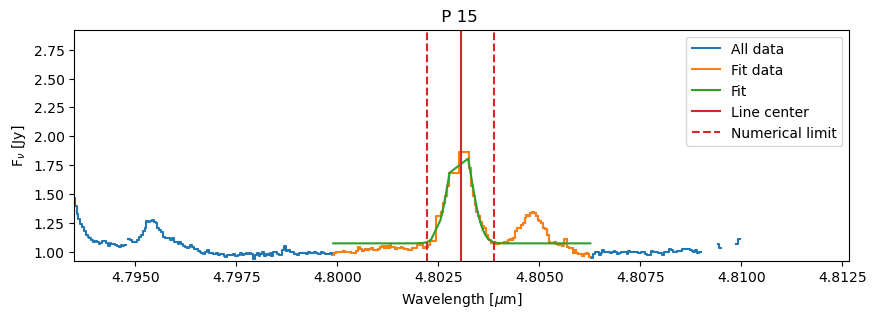

P 14      P 14      
Starting params: 0.1 4.793123722076416 0.00027158151314381315 1.05
7 45
Fit params: 1.082565534312843 4.793137970794396 0.00025701582779205705 1.079537125433602


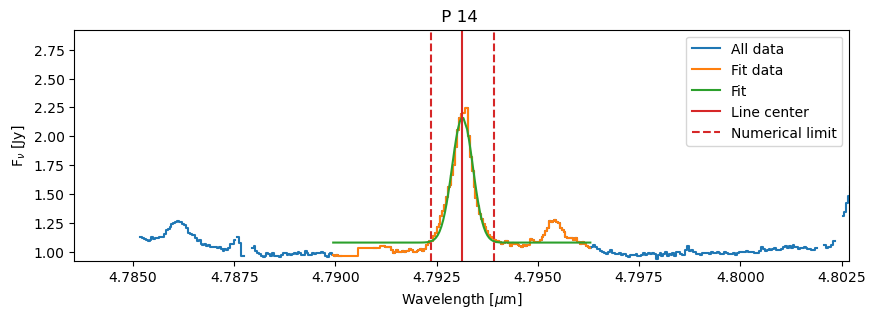

P 12      P 12      
Starting params: 0.1 4.77358341217041 0.0002704743464526781 1.05
0 45
Fit params: 1.0512319333349642 4.773616678031784 0.0002941785793277545 1.0151989619584476


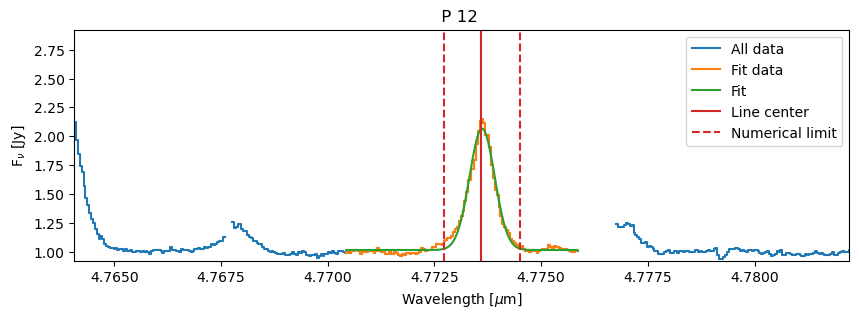

P 11      P 11      
Starting params: 0.1 4.763985633850098 0.00026993053007943416 1.05
0 54
Fit params: 1.0448181209443015 4.764006437647535 0.00028511402116965153 1.0118758438749575


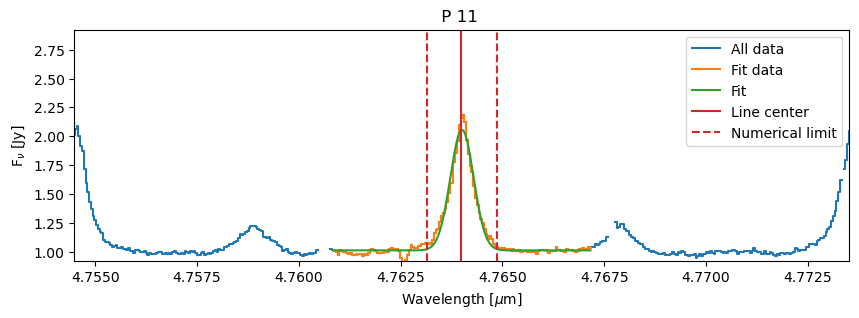

P 10      P 10      
Starting params: 0.1 4.754501819610596 0.0002693931709852643 1.05
0 57
Fit params: 0.925224139628204 4.754535406625543 0.0003066433342822541 1.0007797737029795


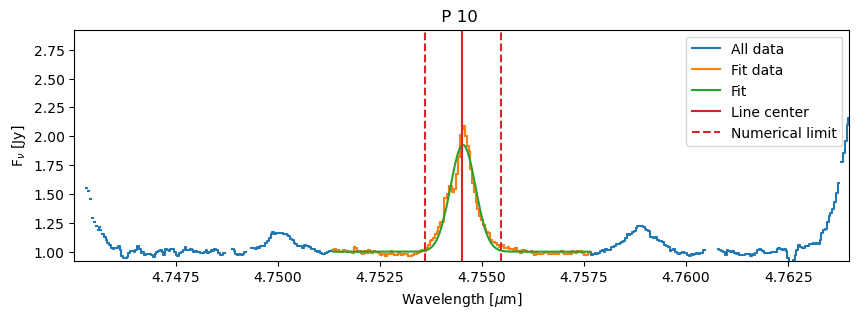

P  8      P  8      
Starting params: 0.1 4.735873222351074 0.00026833766252672283 1.05
0 39
Fit params: 1.0188185160622873 4.735938639195193 0.0002492847165594544 1.006075526098661


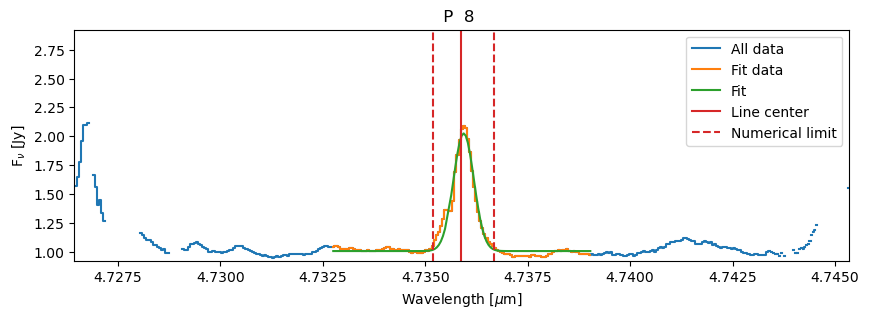

P  7      P  7      
Starting params: 0.1 4.72672700881958 0.0002678194321086389 1.05
0 27
Fit params: 0.973569017679023 4.726700619561221 0.0002690633689372607 1.0290103073587906


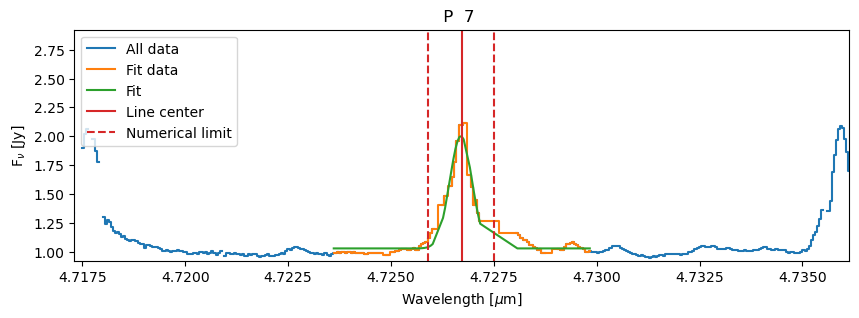

P  6      P  6      
Starting params: 0.1 4.717691421508789 0.00026730746984430067 1.05
0 41
Fit params: 1.0201781369739313 4.717661413144314 0.000263534718393928 1.0255735562846238


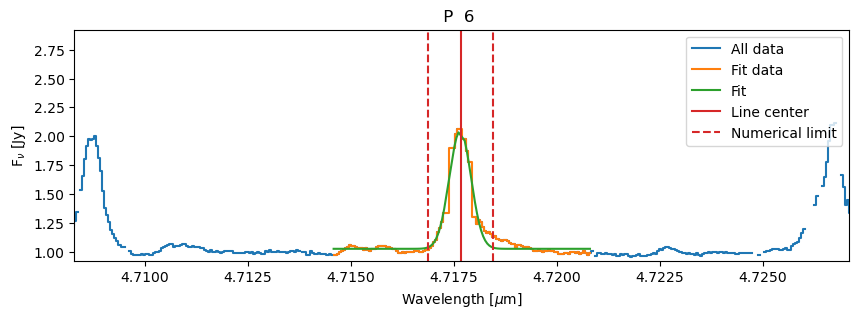

P  5      P  5      
Starting params: 0.1 4.708765983581543 0.000266801748715804 1.05
0 40
Fit params: 0.9727973143138916 4.708723118895721 0.00024637811116836884 1.0323684776727646


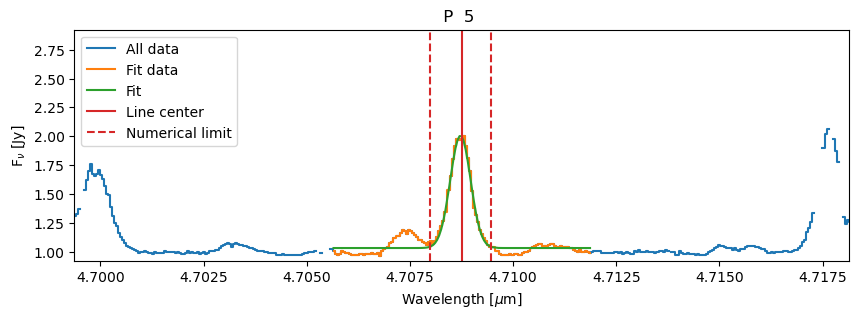

In [6]:
# calculate line shapes for each set of transitions

lineflux_data_high_energy = manual_line_fitting(wave, flux, hitran_data, highenname, fwhm_v=40., sep_v=200.,
                                                cont=np.copy(cont_jy),verbose=True,vet_fits=False,
                                                plot=True,v_dop=0,amp=0.1,ymin=None,ymax=None,bounds=None)

lineflux_data_low_energy = manual_line_fitting(wave, flux, hitran_data, lowenname, fwhm_v=40., sep_v=200.,
                                                cont=np.copy(cont_jy),verbose=True,vet_fits=False,
                                                plot=True,v_dop=0,amp=0.1,ymin=None,ymax=None,bounds=None)

lineflux_data_all_transitions = manual_line_fitting(wave, flux, hitran_data, t_list, fwhm_v=40., sep_v=200.,
                                                cont=np.copy(cont_jy),verbose=True,vet_fits=False,
                                                plot=True,v_dop=0,amp=0.1,ymin=None,ymax=None,bounds=None)

Reading partition function from:  https://hitran.org/data/Q/q26.txt
{
 "tmin": 300,
 "tmax": 2100,
 "lognmin": 14,
 "lognmax": 26,
 "logomegamin": -22,
 "logomegamax": -10,
 "Nwalkers": 25,
 "Nburnin": 1000,
 "Nsamples": 6000
}
running retrieval...
Number of total samples: 150000
Run time [s]: 122.83796310424805


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

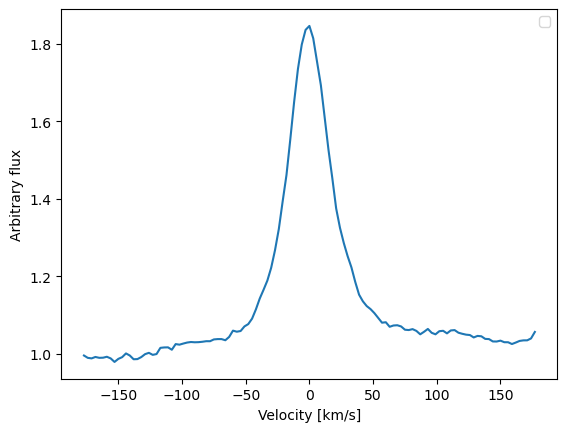

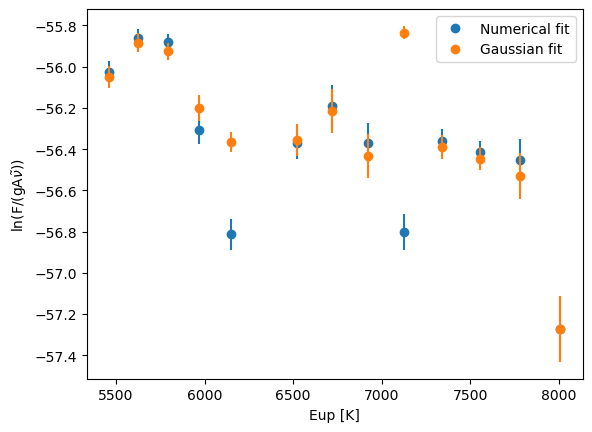

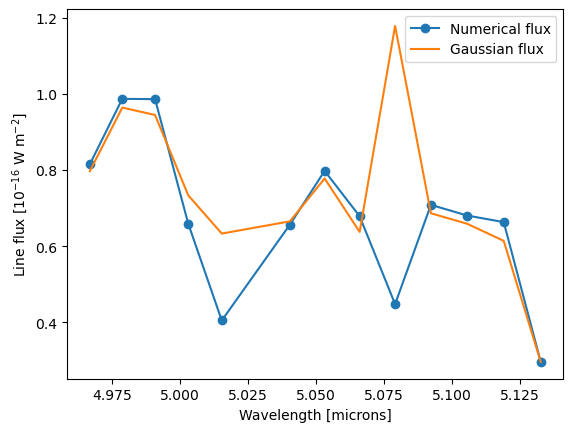

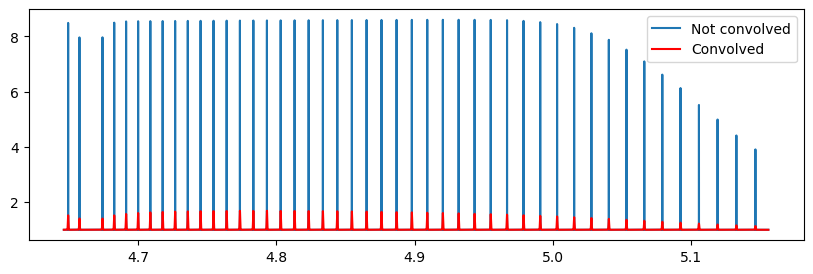

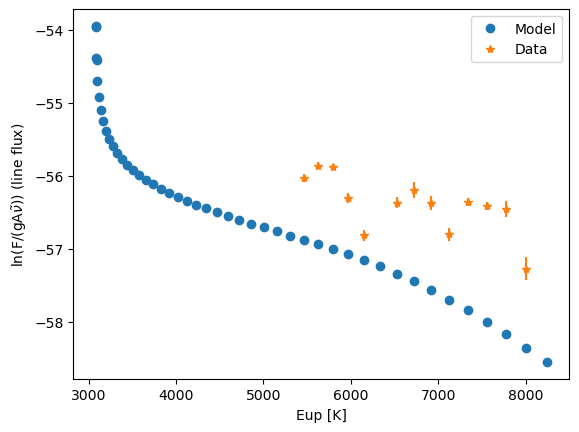

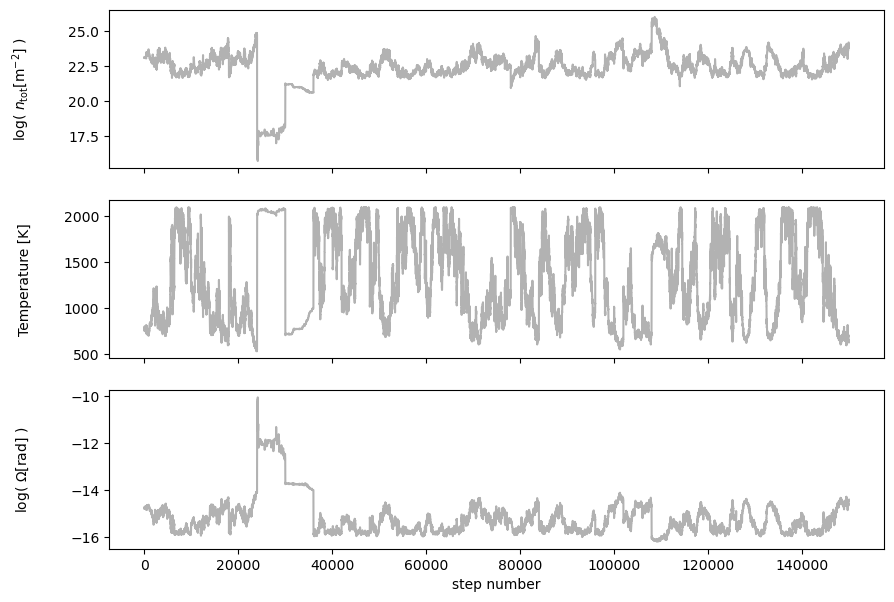

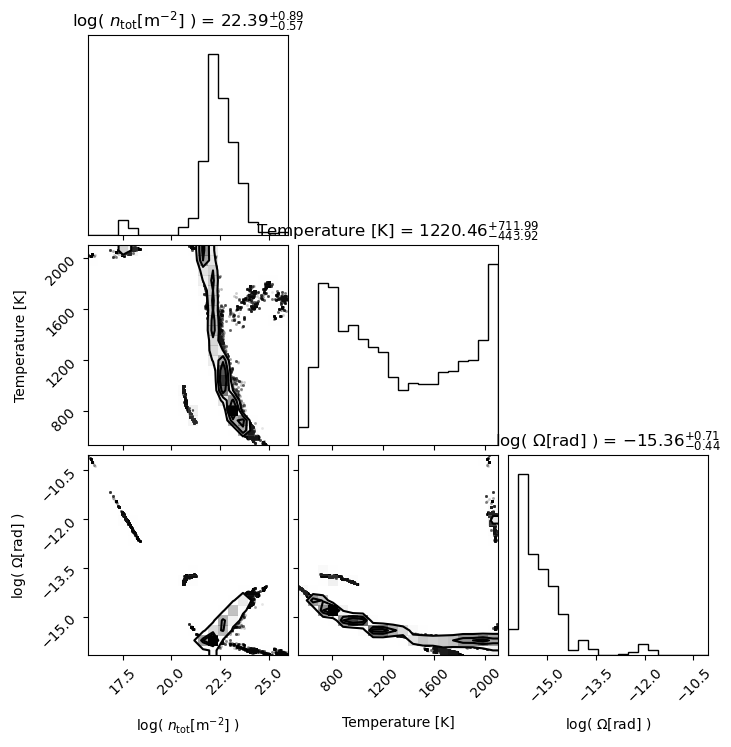

In [22]:
# high energy fits
logN_high, logN_perr_high, logN_nerr_high, T_high, T_perr_high, T_nerr_high, logOmega_high, logOmega_perr_high, logOmega_nerr_high = \
slabspec_routines(wl, flux, wl_min, wl_max, lineflux_data_high_energy, distance, config_file, \
                chain_name=plot_location+label+'_high_energy_'+chain_name, sampler_name=plot_location+label+'_high_energy_'+sampler_name,\
                                      run_retrieval=1, plot_query=1)

Reading partition function from:  https://hitran.org/data/Q/q26.txt
{
 "tmin": 300,
 "tmax": 2100,
 "lognmin": 14,
 "lognmax": 26,
 "logomegamin": -22,
 "logomegamax": -10,
 "Nwalkers": 25,
 "Nburnin": 1000,
 "Nsamples": 6000
}
running retrieval...
Number of total samples: 150000
Run time [s]: 110.76844906806946


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

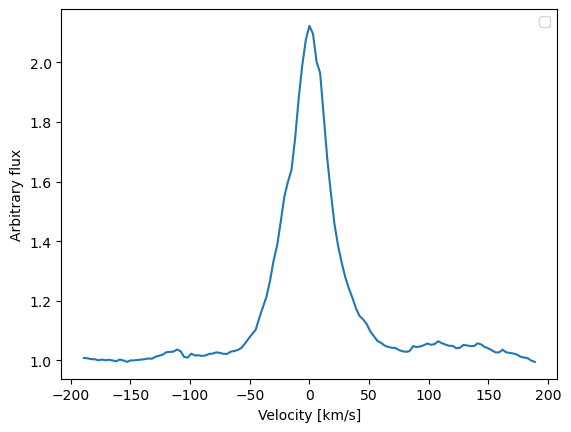

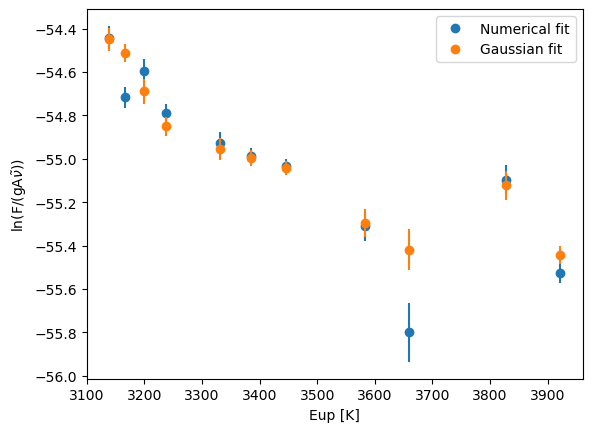

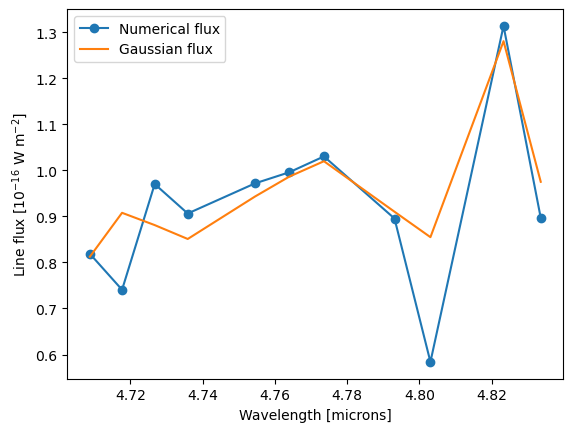

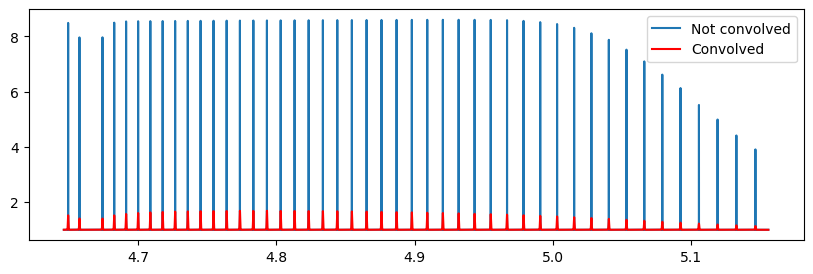

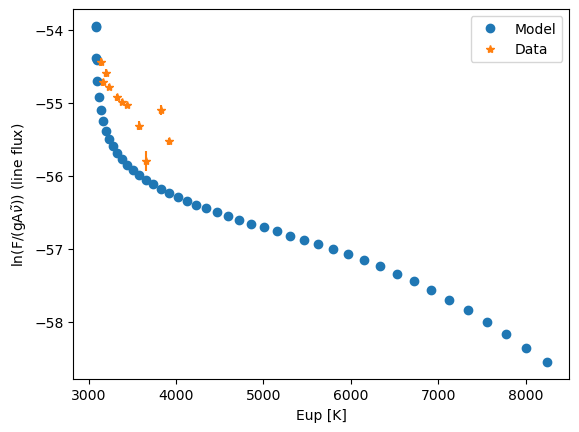

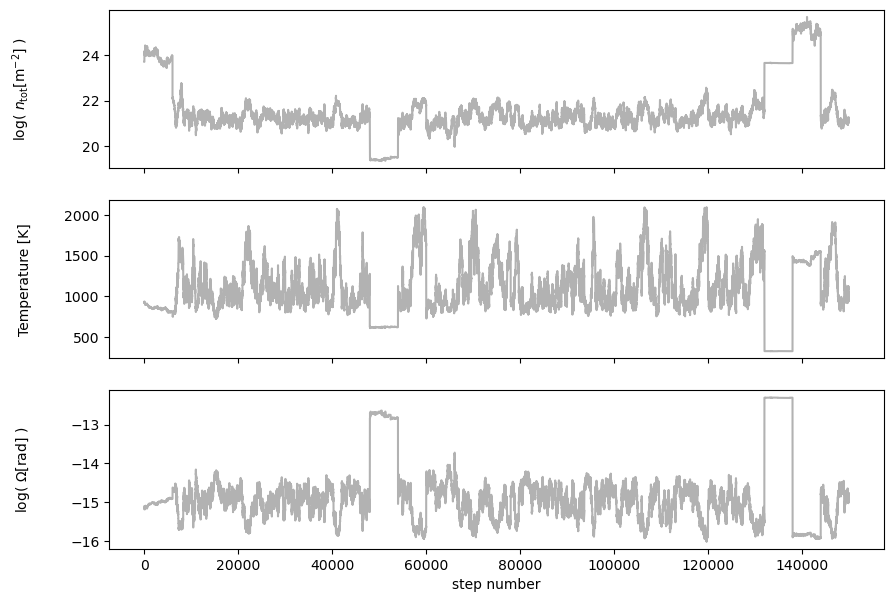

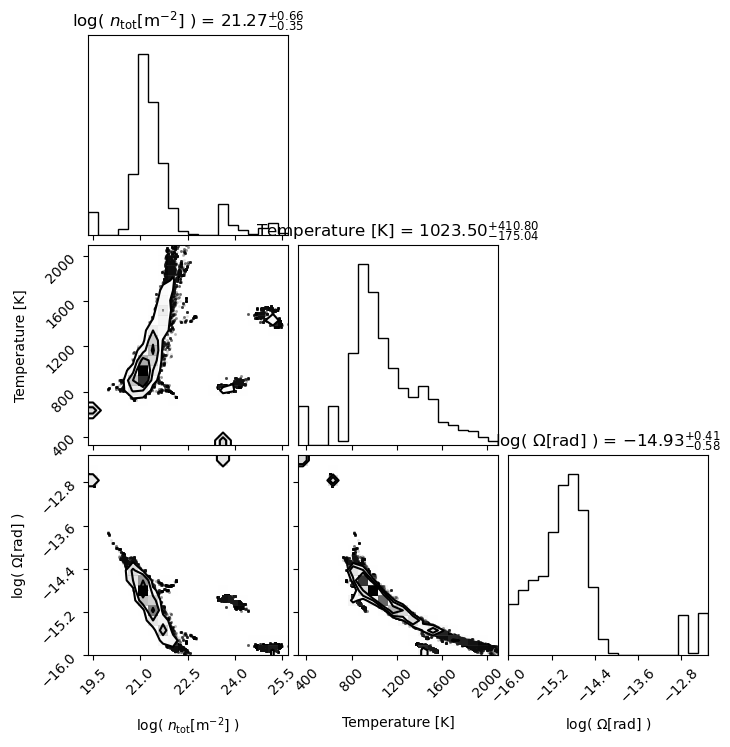

In [23]:
# low energy fits
logN_low, logN_perr_low, logN_nerr_low, T_low, T_perr_low, T_nerr_low, logOmega_low, logOmega_perr_low, logOmega_nerr_low = \
                    slabspec_routines(wl, flux, wl_min, wl_max, lineflux_data_low_energy, distance, config_file, \
                    chain_name=plot_location+label+'_low_energy_'+chain_name, sampler_name=plot_location+label+'_low_energy_'+sampler_name, \
                                      run_retrieval=1, plot_query=1)

Reading partition function from:  https://hitran.org/data/Q/q26.txt
{
 "tmin": 300,
 "tmax": 2100,
 "lognmin": 14,
 "lognmax": 26,
 "logomegamin": -22,
 "logomegamax": -10,
 "Nwalkers": 25,
 "Nburnin": 1000,
 "Nsamples": 6000
}
running retrieval...
Number of total samples: 150000
Run time [s]: 176.63926315307617


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

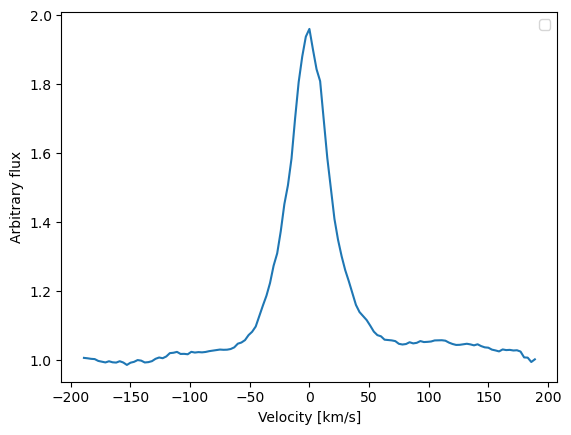

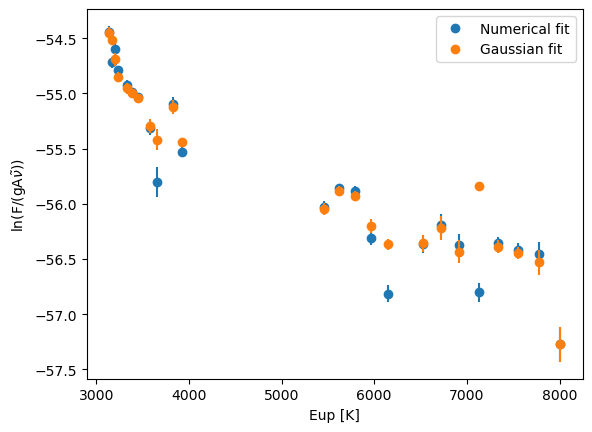

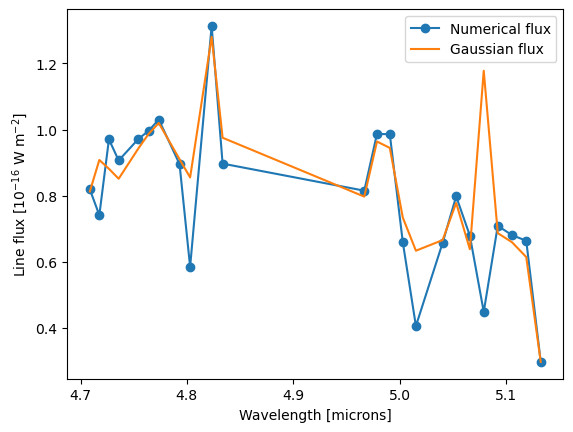

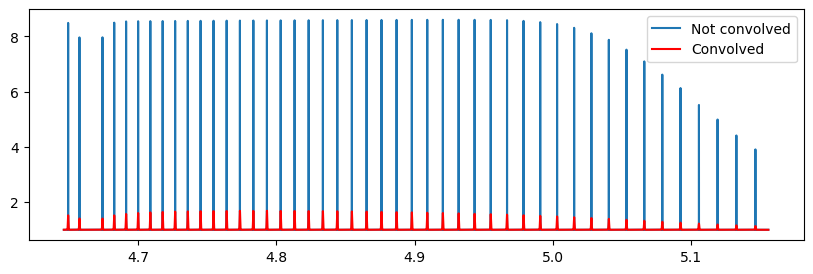

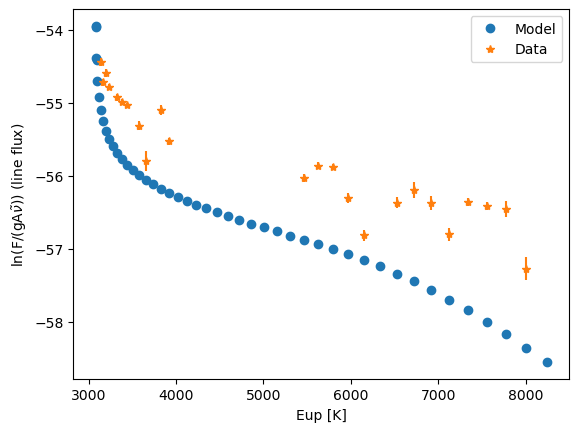

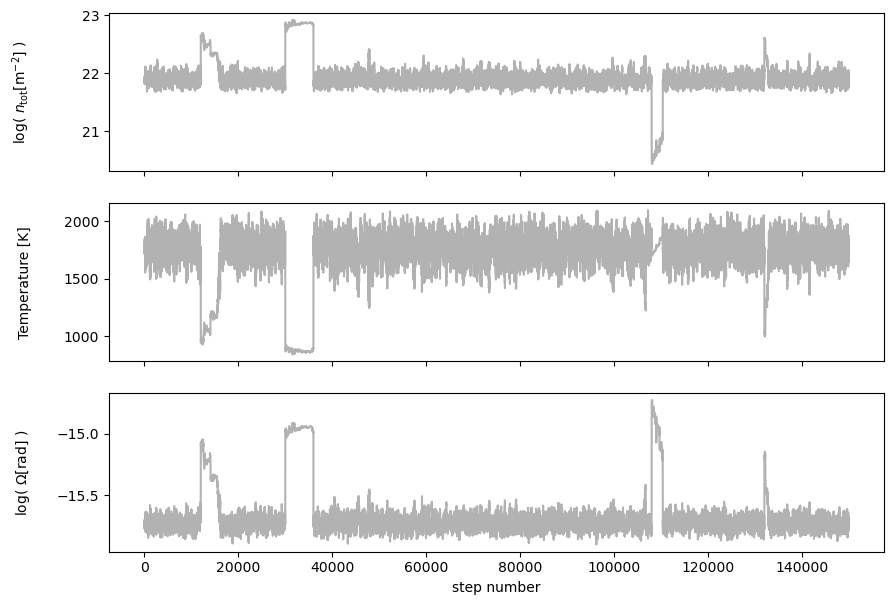

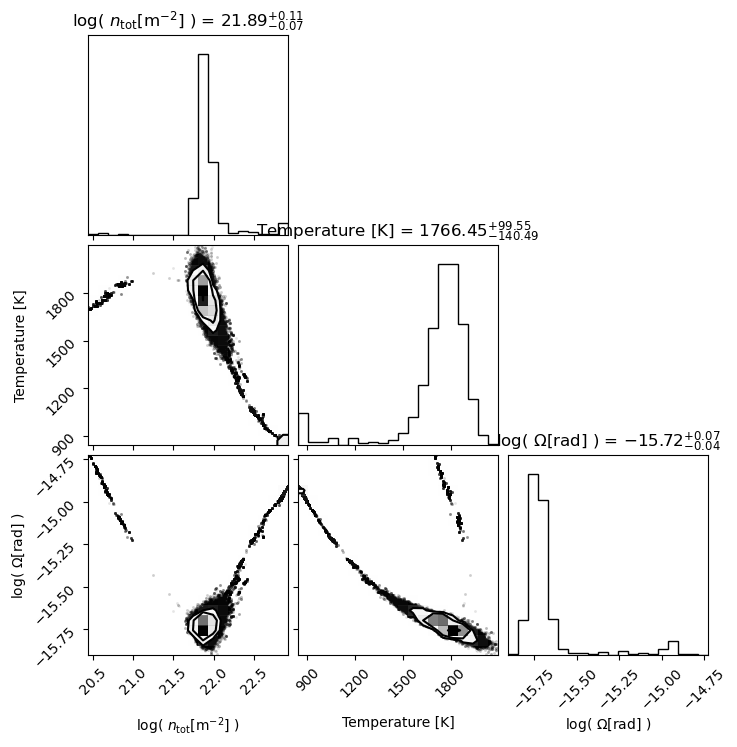

In [24]:
# overall fits
logN_all, logN_perr_all, logN_nerr_all, T_all, T_perr_all, T_nerr_all, logOmega_all, logOmega_perr_all, logOmega_nerr_all = \
                    slabspec_routines(wl, flux, wl_min, wl_max, lineflux_data_all_transitions, distance, config_file, \
                    chain_name=plot_location+label+'_all_'+chain_name, sampler_name=plot_location+label+'_all_'+sampler_name, \
                                      run_retrieval=1, plot_query=1)

In [ ]:
### repeat for other molecules of interest ~

## make output file that can be read by iris scripts

In [25]:
# include lines that were used for each set of solutions

file = open(plot_location+output_file,'w')

# name of disk
file.write(source_name+' \n')

# location to which plots were saved
file.write('data file used: '+datafile+' \n')
file.write('config file used: '+config_file+' \n')
file.write('plots and outputs saved to: '+plot_location+' \n')
file.write('chain file name: '+chain_name+' \n')
file.write('sampler file name: '+sampler_name+' \n')
file.write(' - - - - - - - - - - - - - \n')

# info on how lines were extracted
# ? What to put here? What info will we need later? Or, save different output file w/ line info?

# 12CO, high J-terms (inner region of disk)
file.write(label+' - high J \n')

file.write(str(round(logN_high,8))+' # log N, m^-2 \n')
file.write(str(round(logN_perr_high,8))+' # log N +error, m^-2 \n')
file.write(str(round(logN_nerr_high,8))+' # log N -error, m^-2 \n')

file.write(str(round(T_high,8))+' # T, K \n')
file.write(str(round(T_perr_high,8))+' # T +error, K \n')
file.write(str(round(T_nerr_high,8))+' # T -error, K \n')

file.write(str(round(logOmega_high,8))+' # log omega, rad \n')
file.write(str(round(logOmega_perr_high,8))+' # log omega +error, rad \n')
file.write(str(round(logOmega_nerr_high,8))+' # log omega -error, rad \n')


# 12CO, low J-terms (outer region of disk)
file.write(label+' - low J \n')

file.write(str(round(logN_low,8))+' # log N, m^-2 \n')
file.write(str(round(logN_perr_low,8))+' # log N +error, m^-2 \n')
file.write(str(round(logN_nerr_low,8))+' # log N -error, m^-2 \n')

file.write(str(round(T_low,8))+' # T, K \n')
file.write(str(round(T_perr_low,8))+' # T +error, K \n')
file.write(str(round(T_nerr_low,8))+' # T -error, K \n')

file.write(str(round(logOmega_low,8))+' # log omega, rad \n')
file.write(str(round(logOmega_perr_low,8))+' # log omega +error, rad \n')
file.write(str(round(logOmega_nerr_low,8))+' # log omega -error, rad \n')

# 12CO, all available lines
file.write(label+' - all J \n')

file.write(str(round(logN_all,8))+' # log N, m^-2 \n')
file.write(str(round(logN_perr_all,8))+' # log N +error, m^-2 \n')
file.write(str(round(logN_nerr_all,8))+' # log N -error, m^-2 \n')

file.write(str(round(T_all,8))+' # T, K \n')
file.write(str(round(T_perr_all,8))+' # T +error, K \n')
file.write(str(round(T_nerr_all,8))+' # T -error, K \n')

file.write(str(round(logOmega_all,8))+' # log omega, rad \n')
file.write(str(round(logOmega_perr_all,8))+' # log omega +error, rad \n')
file.write(str(round(logOmega_nerr_all,8))+' # log omega -error, rad \n')



file.close()
